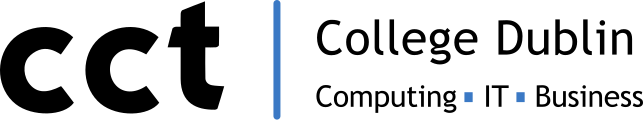

<div style="text-align: center;">
    <h2><u>CA2: Machine Learning for AI</u></h1>
    <h3>Lecturer: David McQuaid</h3>
    <h3>Student Name: Danrlei da Silva Martins</h3>
    <h3>Student Number: 2020322</h3>
    <h3><a href="https://github.com/danrlei-martins-cct/ML_CA2">GitHub Repository</a></h3>
</div>

***

## Assignment Scenario Part I - Neural Networks
- You are required to take data stored file “BankRecords.csv”, available on Moodle and process the data into a DataFrame.
- You are then required to train a Neural Network to predict the “Income(Thousands’)” of the customers, including tuning the network to achieve the best results.
- You must also compare your neural network to a standard ML regressor of your choosing and discuss your findings in the context of the problem at hand.

In [1]:
# pip install tensorflow
# pip install keras
# pip install scikeras
# pip install wordcloud

In [60]:
# Import required libraries for the project
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import re
import nltk

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout
from scikeras.wrappers import KerasRegressor
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud

### 1. Data Understanding

In [112]:
# Load dataset
df = pd.read_csv("BankRecords.csv")

In [4]:
# Check the shape (rows, columns)
df.shape

(5000, 14)

In [5]:
# Check first observations
df.head()

,ID,Age,Experience(Years),Income(Thousands's),Sort Code,Family,Credit Score,Education,Mortgage(Thousands's),Personal Loan,Securities Account,CD Account,Online Banking,CreditCard
0,1,25,1,49,91107,4,1.6,Diploma,0,No,Yes,No,No,No
1,2,45,19,34,90089,3,1.5,Diploma,0,No,Yes,No,No,No
2,3,39,15,11,94720,1,1.0,Diploma,0,No,No,No,No,No
3,4,35,9,100,94112,1,2.7,Degree,0,No,No,No,No,No
4,5,35,8,45,91330,4,1.0,Degree,0,No,No,No,No,Yes


In [6]:
# Get summary statistics
df.describe()

,ID,Age,Experience(Years),Income(Thousands's),Sort Code,Family,Credit Score,Mortgage(Thousands's)
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,56.498800
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,101.713802
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,101.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,635.000000


In [7]:
# Check for missing values
df.isna().sum()

ID                       0
Age                      0
Experience(Years)        0
Income(Thousands's)      0
Sort Code                0
Family                   0
Credit Score             0
Education                0
Mortgage(Thousands's)    0
Personal Loan            0
Securities Account       0
CD Account               0
Online Banking           0
CreditCard               0
dtype: int64

In [8]:
# Check for features data types
df.dtypes

ID                         int64
Age                        int64
Experience(Years)          int64
Income(Thousands's)        int64
Sort Code                  int64
Family                     int64
Credit Score             float64
Education                 object
Mortgage(Thousands's)      int64
Personal Loan             object
Securities Account        object
CD Account                object
Online Banking            object
CreditCard                object
dtype: object

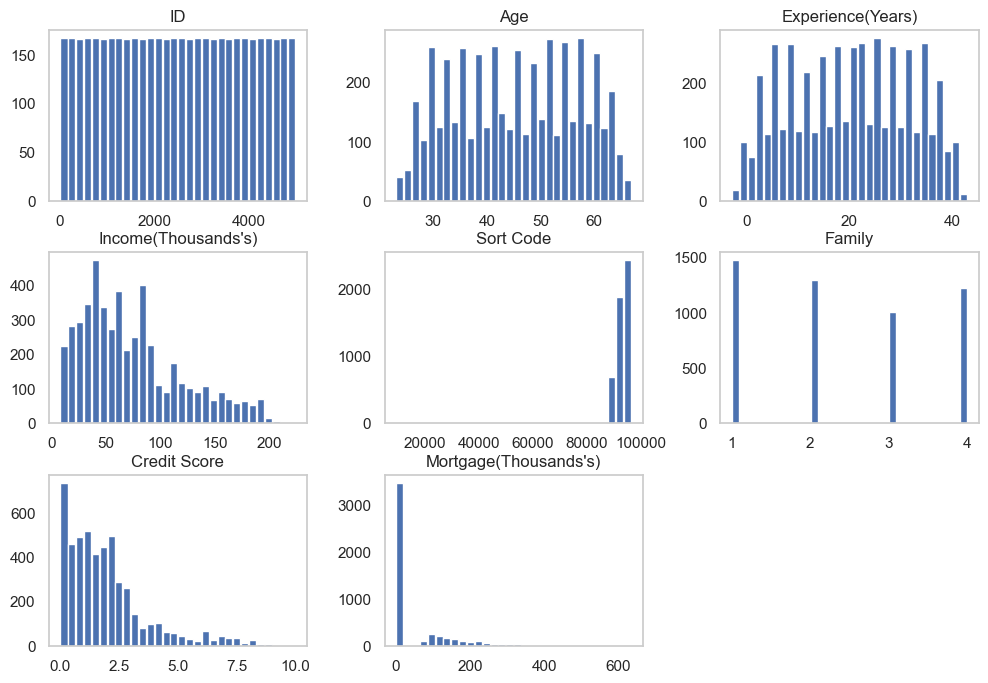

In [120]:
# Display distribution plots
df.hist(bins=30, 
        grid=False, 
        figsize=(12,8),
        zorder=2, 
        rwidth=0.9);

#### 1.1 Findings

- **Negative Values**:  The 'Experience(Years)' column contains negative values, which is unexpected. Experience is typically considered a non-negative quantity. This could potentially indicate data entry errors or outliers that need to be addressed during data preparation.
- **Data Distribution**:
    - Age: The distribution of ages appears to be fairly uniform.
    - Income: The income distribution seems to be right-skewed, with most individuals having lower incomes and a few with significantly higher incomes.
    - Credit Score: The credit score distribution is also right-skewed, it shows a peak around lower values, with a gradual decrease in frequency as scores increase.
    - Mortgage: Most individuals seem to have no mortgage, as indicated by the peak at 0, with a few having higher mortgage amounts, leading to a right-skewed distribution.
- **Data Completeness**: There are no missing values in any of the columns, which is a positive aspect indicating that the dataset is relatively clean in terms of missing data.

***

### 2. Data Preparation

In [3]:
# Drop 'ID' and 'Sort Code' columns
df.drop(['ID', 'Sort Code'], axis=1, inplace=True)

In [4]:
# Checking for negative values
negative_values = (df.select_dtypes(include=[float, int]) < 0).sum()
display(negative_values)

Age                       0
Experience(Years)        52
Income(Thousands's)       0
Family                    0
Credit Score              0
Mortgage(Thousands's)     0
dtype: int64

In [5]:
# Checking unique negative values in "Experience(Years)" column
negative_experience = df[df['Experience(Years)'] < 0]['Experience(Years)'].unique()
print(negative_experience)

[-1 -2 -3]


In [6]:
# Replace negative values in "Experience(Years)" column with 0
df.loc[df["Experience(Years)"] < 0, "Experience(Years)"] = 0

In [7]:
# Define feature columns and target column
features = df.drop("Income(Thousands's)", axis=1)
target = df["Income(Thousands's)"]

In [15]:
features

,Age,Experience(Years),Family,Credit Score,Education,Mortgage(Thousands's),Personal Loan,Securities Account,CD Account,Online Banking,CreditCard
0,25,1,4,1.6,Diploma,0,No,Yes,No,No,No
1,45,19,3,1.5,Diploma,0,No,Yes,No,No,No
2,39,15,1,1.0,Diploma,0,No,No,No,No,No
3,35,9,1,2.7,Degree,0,No,No,No,No,No
4,35,8,4,1.0,Degree,0,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,1,1.9,Masters,0,No,No,No,Yes,No
4996,30,4,4,0.4,Diploma,85,No,No,No,Yes,No
4997,63,39,2,0.3,Masters,0,No,No,No,No,No
4998,65,40,3,0.5,Degree,0,No,No,No,Yes,No


In [16]:
target

0        49
1        34
2        11
3       100
4        45
       ... 
4995     40
4996     15
4997     24
4998     49
4999     83
Name: Income(Thousands's), Length: 5000, dtype: int64

In [8]:
# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object']).columns
numerical_cols = features.select_dtypes(include=['int64', 'float64']).columns

In [9]:
# Define preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [10]:
# Combine preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [11]:
# Apply preprocessing to features
X = preprocessor.fit_transform(features)
y = target.values

In [12]:
X

array([[-1.77441684, -1.67139016,  1.39741398, ...,  0.        ,
         1.        ,  0.        ],
       [-0.02952359, -0.09787278,  0.52599094, ...,  0.        ,
         1.        ,  0.        ],
       [-0.55299157, -0.44754331, -1.21685513, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.54088033,  1.65047986, -0.34543209, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.71536965,  1.73789749,  0.52599094, ...,  1.        ,
         1.        ,  0.        ],
       [-1.51268285, -1.40913726,  0.52599094, ...,  1.        ,
         0.        ,  1.        ]])

In [13]:
y

array([49, 34, 11, ..., 24, 49, 83], dtype=int64)

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 2.1 Rationale

- **Feature Engineering - Dropping Columns**: The 'ID' and 'Sort Code' columns were dropped as they are simply identifiers and do not provide any relevant information for the analysis or modeling process. This simplifies the dataset and reduces unnecessary dimensionality.
- **Handling Negative Values**: The negative values identified in the 'Experience' column were addressed, which is crucial for maintaining the integrity of the data. These negative values were likely due to data entry errors or outliers, and replacing them with zeros ensures consistency and avoids potential distortions in analysis.
- **Defining Features and Target**: The data was separated into feature columns and the target column ('Income'). This step is essential for supervised learning tasks, as it defines the inputs (features) and outputs (target variable) for predictive models.
- **Preprocessing Pipelines**: Preprocessing pipelines were defined for numerical and categorical features separately. This allows to apply different transformations to each type of feature, as follows:
    - The numerical features were scaled using the Standard Scaler method.
    - The categorical features were encoded using the One-Hot Encoding technique.
- **Data Splitting**: The preprocessed data was split into training and testing sets to evaluate the performance of predictive models. This step helps to assess how well the models generalize to unseen data and avoid overfitting.

---

### 3. Modelling

#### 3.1 Baseline Neural Network Model

In [52]:
# Define a neural network architecture
# Source: https://keras.io/guides/sequential_model/; https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Define the input shape
input_shape = (X_train.shape[1],)

# Create the model
model = Sequential([                  # Initialize the Sequential model
    Input(shape=input_shape),         # Add the input layer
    Dense(64, activation='relu'),     # Add the first hidden layer
    Dense(32, activation='relu'),     # Add the second hidden layer
    Dense(1)                          # Add the output layer
])

In [53]:
# Compile the model
# Source: https://keras.io/api/metrics/; https://keras.io/api/metrics/regression_metrics/
model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['mean_absolute_error'])

In [54]:
# Display the model's summary
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 64)                  │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Train the model
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/Model; https://keras.io/api/models/model_training_apis/
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=1)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7399.9897 - mean_absolute_error: 71.9816 - val_loss: 3699.8408 - val_mean_absolute_error: 46.1704
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2954.2439 - mean_absolute_error: 39.9555 - val_loss: 1141.9780 - val_mean_absolute_error: 27.7657
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1339.9553 - mean_absolute_error: 29.6306 - val_loss: 925.4426 - val_mean_absolute_error: 24.9321
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1097.7852 - mean_absolute_error: 26.8645 - val_loss: 861.5872 - val_mean_absolute_error: 23.8010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1083.1676 - mean_absolute_error: 26.0763 - val_loss: 835.6315 - val_mean_absolute_error: 23.3598
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 974.0575 - mean_absolute_error: 24.8774 - val_loss: 823.3593 - val_mean_absolute_error: 22.8296
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

Epoch 86/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 691.4404 - mean_absolute_error: 20.2400 - val_loss: 684.2078 - val_mean_absolute_error: 20.8823
Epoch 87/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 721.0864 - mean_absolute_error: 20.8869 - val_loss: 682.4729 - val_mean_absolute_error: 20.7963
Epoch 88/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 722.6679 - mean_absolute_error: 21.0200 - val_loss: 682.5826 - val_mean_absolute_error: 20.6462
Epoch 89/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 712.4348 - mean_absolute_error: 20.7222 - val_loss: 690.3974 - val_mean_absolute_error: 20.4634
Epoch 90/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 718.6230 - mean_absolute_error: 20.4737 - val_loss: 684.4719 - val_mean_absolute_error: 20.8381
Epoch 91/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 740.1371 - mean_absolute_error: 20.7990 - val_loss: 688.9366 - val_mean_absolute_error: 20.4760
Epoch 92/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

#### Rationale

**Model Architecture**
   - The baseline model has a relatively simple architecture with two hidden layers containing 64 and 32 neurons, respectively.
   - The ReLU activation function is used in the hidden layers, which is a common choice for introducing non-linearity in neural networks (Brownlee, 2019).
   - The output layer has a single neuron, which is suitable for a regression task where the goal is to predict a continuous target variable (e.g. income).  

#### 3.2 Hyperparameter Tuning

In [34]:
# Define a function to create the model with given hyperparameters
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
def create_model(optimizer='adam', activation='relu', neurons=16, learning_rate=0.001, dropout_rate=0.0):
    
    # Initialize the Sequential model
    model = Sequential() 
    
    # Add the first Dense layer with the specified number of neurons, activation function, and input shape
    model.add(Dense(neurons, activation=activation, input_shape=[X_train.shape[1]]))
    
    # Add a Dropout layer with the specified dropout rate
    model.add(Dropout(dropout_rate))                 
    
    # Add a second Dense layer with the same number of neurons and activation function
    model.add(Dense(neurons, activation=activation))
    
    # Add another Dropout layer with the specified dropout rate
    model.add(Dropout(dropout_rate))
    
    # Add the output layer with one neuron
    model.add(Dense(1))
    
    # Create the optimizer with the specified learning rate
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    
    # Compile the model with the specified optimizer and mean squared error loss function
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

In [35]:
# Define the hyperparameter grid
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [50, 100, 150],
    'activation': ['relu', 'sigmoid'],
    'neurons': [16, 32, 64, 128],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3]
}

In [36]:
# Set up the GridSearchCV with KerasRegressor
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_search = GridSearchCV(
    estimator=KerasRegressor(build_fn=create_model, 
                             optimizer='adam', 
                             activation='relu', 
                             neurons=16,
                             learning_rate=0.001, 
                             dropout_rate=0.0, 
                             verbose=3),
    param_grid=param_grid,                          # Grid of hyperparameters to search
    scoring='neg_mean_squared_error',               # Scoring function to use
    cv=3,                                           # Number of cross-validation folds
    n_jobs=-1,                                      # Use all available cores
    verbose=3
)

In [37]:
# Fit the GridSearchCV to the training data
grid_result = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


C:\Users\danrl\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\danrl\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\danrl\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
Epoch 9/150
Epoch 10/150
Epoch 11/150
Epoch 12/150
Epoch 13/150
Epoch 14/150
Epoch 15/150
Epoch 16/150
Epoch 17/150
Epoch 18/150
Epoch 19/150
Epoch 20/150
Epoch 21/150
Epoch 22/150
Epoch 23/150
Epoch 24/150
Epoch 25/150
Epoch 26/150
Epoch 27/150
Epoch 28/150
Epoch 29/150
Epoch 30/150
Epoch 31/150
Epoch 32/150
Epoch 33/150
Epoch 34/150
Epoch 35/150
Epoch 36/150
Epoch 37/150
Epoch 38/150
Epoch 39/150
Epoch 40/150
Epoch 41/150
Epoch 42/150
Epoch 43/150
Epoch 44/150
Epoch 45/150
Epoch 46/150
Epoch 47/150
Epoch 48/150
Epoch 49/150
Epoch 50/150
Epoch 51/150
Epoch 52/150
Epoch 53/150
Epoch 54/150
Epoch 55/150
Epoch 56/150
Epoch 57/150
Epoch 58/150
Epoch 59/150
Epoch 60/150
Epoch 61/150
Epoch 62/150
Epoch 63/150
Epoch 64/150
Epoch 65/150
Epoch 66/150
Epoch 67/150
Epoch 68/150
Epoch 69/150
Epoch 70/150
Epoch 71/150
Epoch 72/150
Epoch 73/150
Epoch 74/150
Epoch 75/150
Epoch 76/150
Epoch 77/150
Epoch 78

In [39]:
# Display best parameters found by GridSearchCV
print("Best Parameters: ", grid_result.best_params_)

Best Parameters:  {'activation': 'sigmoid', 'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 150, 'learning_rate': 0.01, 'neurons': 128, 'optimizer': 'sgd'}


#### Rationale

The _create_model_ function defines the backbone to build a sequential neural network model in Keras with customizable hyperparameters such as optimizer, activation function, number of neurons, learning rate, and dropout rate (SciKit Learn, 2019). A hyperparameter grid _param_grid_ was set up containing various combinations of these hyperparameters to be explored.

**GridSearchCV** is then used to perform an exhaustive search over the specified hyperparameter grid. It is configured to use negative mean squared error as the scoring metric, employ 3-fold cross-validation, and leverage all available CPU cores for parallel processing.

The search consisted of 3 folds for each of 1728 candidates, totalling 5184 fits. The search took around 12 hours of running time. The best set of hyperparameters was obtained after the search was completed, which was then used for the custom model in the next section.

#### 3.3 Custom Neural Network Model

In [83]:
# Define a custom neural network architecture based on GridSearchCV results
# Source: https://keras.io/guides/sequential_model/; https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Define the input shape
input_shape = (X_train.shape[1],)

# Create the model
custom_model = Sequential([
    Input(shape=input_shape),             # Add the input layer
    Dense(128, activation='sigmoid'),     # Add the first hidden layer
    Dropout(0.3),                         # Add the first dropout layer 
    Dense(128, activation='sigmoid'),     # Add the second hidden layer
    Dropout(0.3),                         # Add the second dropout layer 
    Dense(1)                              # Add the output layer
])


In [84]:
# Compile the model
# Source: https://keras.io/api/metrics/; https://keras.io/api/metrics/regression_metrics/
custom_model.compile(optimizer='sgd',
              loss='mean_squared_error', 
              metrics=['mean_absolute_error'])

In [85]:
# Train the model
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/Model; https://keras.io/api/models/model_training_apis/
custom_history = custom_model.fit(X_train, 
                    y_train, 
                    epochs=150, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=1)

Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2116.7192 - mean_absolute_error: 35.2629 - val_loss: 962.7134 - val_mean_absolute_error: 24.3448
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1115.4618 - mean_absolute_error: 26.1176 - val_loss: 812.3351 - val_mean_absolute_error: 22.9569
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 970.9417 - mean_absolute_error: 24.4383 - val_loss: 785.1289 - val_mean_absolute_error: 22.5651
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 919.8654 - mean_absolute_error: 23.8099 - val_loss: 812.5416 - val_mean_absolute_error: 22.1525
Epoch 5/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 955.5892 - mean_absolute_error: 24.2300 - val_loss: 764.8331 - val_mean_absolute_error: 21.5955
Epoch 6/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 972.9189 - mean_absolute_error: 24.2455 - val_loss: 882.7178 - val_mean_absolute_error: 24.6416
Epoch 7/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

Epoch 86/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 659.1752 - mean_absolute_error: 19.5226 - val_loss: 663.9965 - val_mean_absolute_error: 19.6303
Epoch 87/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 670.2636 - mean_absolute_error: 19.9805 - val_loss: 650.7211 - val_mean_absolute_error: 19.3562
Epoch 88/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 661.7662 - mean_absolute_error: 19.7085 - val_loss: 656.1931 - val_mean_absolute_error: 19.4840
Epoch 89/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 654.3575 - mean_absolute_error: 19.4750 - val_loss: 663.9464 - val_mean_absolute_error: 19.6956
Epoch 90/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 641.9680 - mean_absolute_error: 19.4241 - val_loss: 651.8534 - val_mean_absolute_error: 19.8056
Epoch 91/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 663.8793 - mean_absolute_error: 19.7121 - val_loss: 666.5577 - val_mean_absolute_error: 19.9899
Epoch 92/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

#### 3.4 Standard Random Forest Regressor

In [69]:
# Create a RandomForestRegressor Object
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
rf = RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
# Train the model
rf.fit(X_train, y_train)

***

### 4. Evaluation

#### 4.1 Baseline Model Performance

In [103]:
# Evaluate the base model on the test set
baseline_predictions = model.predict(X_test)

# Calculate Mean Squared Error
baseline_mse = mean_squared_error(y_test, baseline_predictions)

# Calculate Mean Absolute Error
baseline_mae = mean_absolute_error(y_test, baseline_predictions)

# Calculate R-squared
baseline_r2 = r2_score(y_test, baseline_predictions)

# Print the evaluation metrics
print("Baseline Neural Network Model Results")
print(f"Mean Squared Error: {baseline_mse:.2f}")
print(f"Mean Absolute Error: {baseline_mae:.2f}")
print(f"R-squared: {baseline_r2:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Baseline Neural Network Model Results
Mean Squared Error: 704.64
Mean Absolute Error: 20.63
R-squared: 0.67


#### 4.2 Custom Model Performance

In [104]:
# Evaluate the model on the test set
custom_predictions = custom_model.predict(X_test)

# Calculate Mean Squared Error
custom_mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error
custom_mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared
custom_r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Custom Neural Network Model Results")
print(f"Mean Squared Error: {custom_mse:.2f}")
print(f"Mean Absolute Error: {custom_mae:.2f}")
print(f"R-squared: {custom_r2:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Custom Neural Network Model Results
Mean Squared Error: 676.27
Mean Absolute Error: 20.05
R-squared: 0.68


#### 4.3 Random Forest Performance

In [101]:
# Evaluate the rf model on the test set
rf_predictions = rf.predict(X_test)

# Calculate Mean Squared Error
rf_mse = mean_squared_error(y_test, rf_predictions)

# Calculate Mean Absolute Error
rf_mae = mean_absolute_error(y_test, rf_predictions)

# Calculate R-squared
rf_r2 = r2_score(y_test, rf_predictions)

print(f'Random Forest MSE: {rf_mse:.2f}')
print(f'Random Forest MAE: {rf_mae:.2f}')
print(f'Random Forest R2 Score: {rf_r2:.2f}')

Random Forest MSE: 379.44
Random Forest MAE: 13.82
Random Forest R2 Score: 0.82


#### 4.4 Visualizing Performance

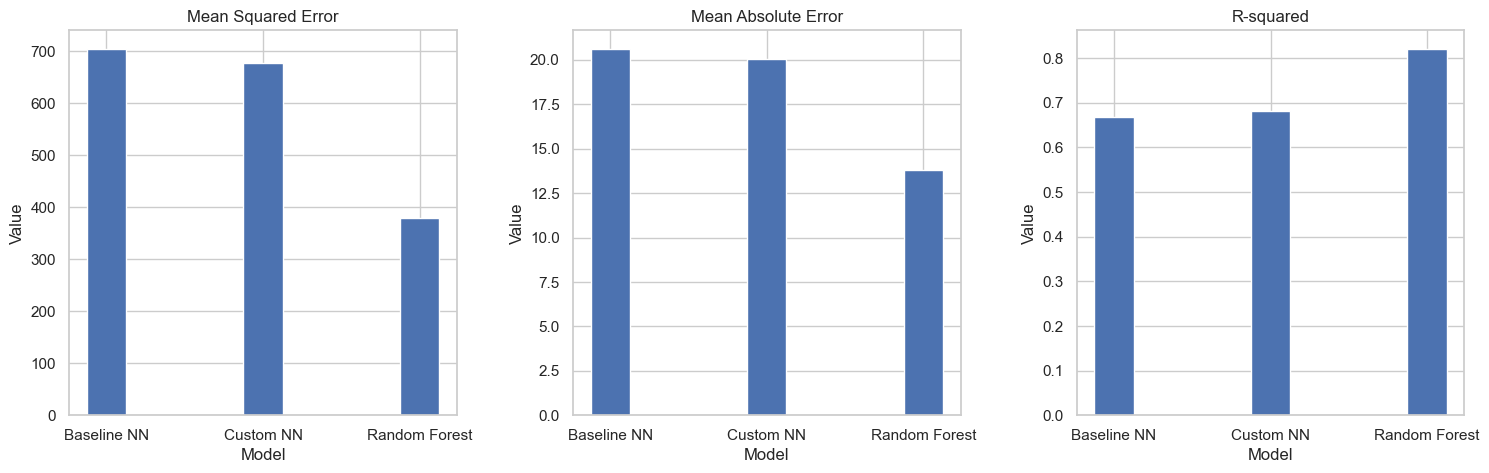

In [107]:
# Create a dictionary with the model names and their corresponding evaluation metrics
model_metrics = {
    'Baseline NN': [baseline_mse, baseline_mae, baseline_r2],
    'Custom NN': [custom_mse, custom_mae, custom_r2],
    'Random Forest': [rf_mse, rf_mae, rf_r2]
}

# Set up a figure and axis
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Set the bar width
bar_width = 0.25

# Create a list of x-axis positions for the bars
x_positions = [0, 1, 2]

# Plot the bars for each metric
for i, ax in enumerate(axes.flatten()):
    metric_values = [metrics[i] for metrics in model_metrics.values()]
    ax.bar(x_positions, metric_values, width=bar_width)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(model_metrics.keys())
    ax.set_title(['Mean Squared Error', 'Mean Absolute Error', 'R-squared'][i])
    ax.set_xlabel('Model')
    ax.set_ylabel('Value')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plot
plt.show()

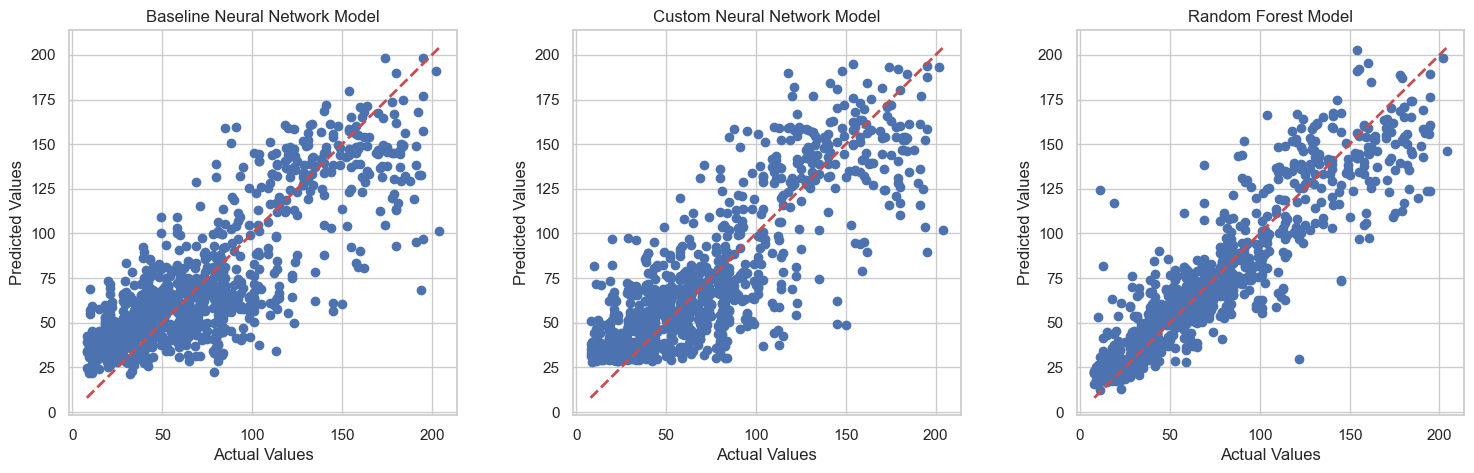

In [109]:
# Create a figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Baseline Neural Network Model
axes[0].scatter(y_test, baseline_predictions)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title('Baseline Neural Network Model')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')

# Custom Neural Network Model
axes[1].scatter(y_test, custom_predictions)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title('Custom Neural Network Model')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')

# Random Forest Model
axes[2].scatter(y_test, rf_predictions)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_title('Random Forest Model')
axes[2].set_xlabel('Actual Values')
axes[2].set_ylabel('Predicted Values')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the plot
plt.show()

In [138]:
def get_feature_names(preprocessor):
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if transformer == 'drop' or isinstance(transformer, str):
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
        else:
            names = columns
        feature_names.extend(names)
    return feature_names

# Extract the feature names from the preprocessor
actual_feature_names = get_feature_names(preprocessor)

In [139]:
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': actual_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
3,Credit Score,0.533299
4,Mortgage(Thousands's),0.077641
0,Age,0.076201
1,Experience(Years),0.075727
2,Family,0.058848
9,Personal Loan_Yes,0.057409
8,Personal Loan_No,0.054348
6,Education_Diploma,0.027310
7,Education_Masters,0.006115
14,Online Banking_No,0.005648


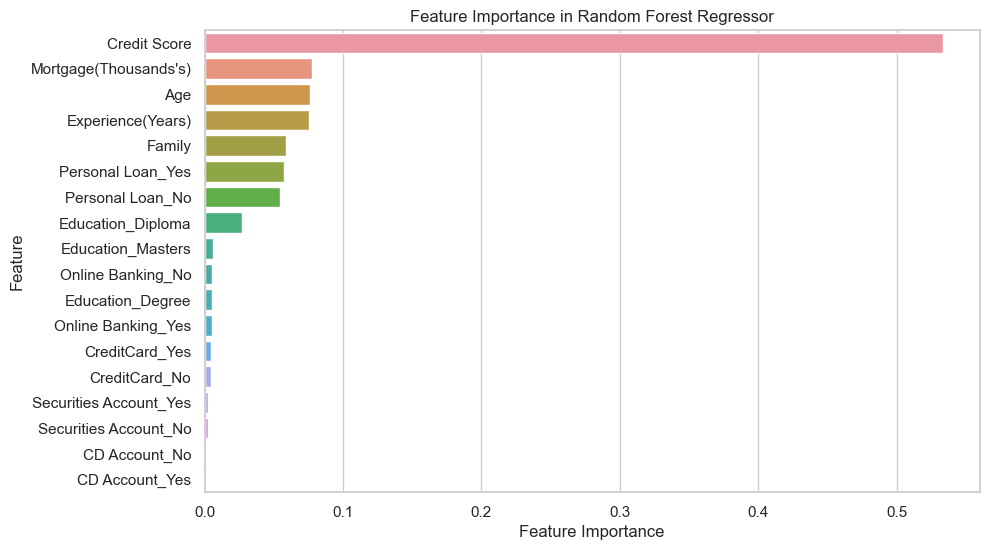

In [141]:
# Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()

#### 4.5 Prediction of a New Customer's Income

In [125]:
features.columns

Index(['Age', 'Experience(Years)', 'Family', 'Credit Score', 'Education',
       'Mortgage(Thousands's)', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online Banking', 'CreditCard'],
      dtype='object')

In [171]:
# Define a new customer's features
new_customer = {
    'Age': 28,
    'Experience(Years)': 10,
    'Family': 1,
    'Credit Score': 3.5,
    'Education': 'Degree',
    "Mortgage(Thousands's)": 0.0,
    'Personal Loan': 'Yes',
    'Securities Account': 'No',
    'CD Account': 'No',
    'Online Banking': 'Yes',
    'CreditCard': 'Yes'
}

# Convert the new customer's data to a DataFrame
new_customer_df = pd.DataFrame([new_customer], columns=features.columns)

new_customer_df

,Age,Experience(Years),Family,Credit Score,Education,Mortgage(Thousands's),Personal Loan,Securities Account,CD Account,Online Banking,CreditCard
0,28,10,1,3.5,Degree,0.0,Yes,No,No,Yes,Yes


In [172]:
# Preprocess the new customer's features
new_customer_data = preprocessor.transform(new_customer_df)

# Make a prediction using the Random Forest Regressor
new_customer_income_prediction = rf.predict(new_customer_data)

print(f"Predicted income for the new customer: {new_customer_income_prediction[0]:.2f} (thousands)")

Predicted income for the new customer: 117.38 (thousands)


#### 4.6 Findings

**Custom Neural Network Model Performance**
- The custom neural network model achieved an MSE of 676.27 and an MAE of 20.05.
- The R-squared score of 0.68 indicates that the custom neural network model could explain approximately 68% of the variance in the income data.
- The custom neural network model performed slightly better in terms of MSE, MAE, and R-squared compared to the baseline neural network model.

**Random Forest Regressor Performance**
- The Random Forest Regressor achieved a MSE of 379.44, an MAE of 13.82, and an R-squared score of 0.82.
- Compared to baseline and custom neural network models, the Random Forest Regressor performed significantly better across all three metrics (MSE, MAE, and R-squared).
- The 'Credit Score' feature has the highest importance score by a significant margin (0.53). Thus, being the most critical factor influencing the 'Income' feature.

**Model Comparison**
- The visualizations clearly compared the three models' performance, with the Random Forest Regressor outperforming both neural network models.
- The scatter plots suggest that the Random Forest Regressor was better able to capture the underlying patterns in the data and had a tighter distribution of errors around the diagonal line.


---

### 5. Conclusion

Overall, the Random Forest Regressor demonstrated superior performance in predicting customers' income. This is likely due to its ability to effectively handle non-linear relationships, robustness to outliers, and the algorithm's inherent ensemble nature (Müller and Guido, 2017). As for the most importante feature of the model, credit score is often highly correlated with income. People with higher incomes tend to have better credit scores because they are more likely to pay their bills on time and manage their debts responsibly. Therefore, the model might be capturing this correlation and using credit score as a proxy for income.

While the custom neural network model showed improvement over the baseline, its performance was still lower than the Random Forest Regressor. This suggests potential for further exploration in the chosen architecture or hyperparameters.

***

## Assignment Scenario Part II - Semantic Analysis
- You are required to source text data from any social media platform on any topic that you choose and perform semantic analysis on the text.
- This analysis should provide a visualization of the overall sentiment of your text data , showing the positive, neutral, and negative sentiment expressed.
- You will require at least 1000 text observations

### Data Collection

I decided to **collect and analyze social media data from YouTube comments to analyze public perception and sentiment surrounding OpenAI's latest developments in AI, particularly the introduction of GPT-4o**.

To gather the data, I watched a video tutorial (Grant, 2024) on how to scrap data using Google's API (Google, 2023) and implemented source code provided by analyticswithadam (2024) to scrape over 600,000 comments from OpenAI's YouTube playlist titled "Introducing GPT-4o" (OpenAI, 2024). This was done in a separate Jupyter Notebook file, as it was run using Google Colab for faster processing. Here is a link to see the code used to gather the text data from the YouTube playlists: https://colab.research.google.com/drive/1SLOnFIJxX18pDrUVvqFD3XTZNnp9h0zU?usp=sharing

By analyzing the semantics expressed in these comments, I aim to assess the general public's perception and reaction towards the recent advancements in AI technology, as exemplified by the release of GPT-4o.

***

### 1. Data Understanding

In [67]:
# Load dataset
openai_youtube_df = pd.read_csv("openai_youtube_comments_data.csv")

In [23]:
# Check the shape (rows, columns)
openai_youtube_df.shape

(665810, 5)

In [68]:
# Check first observations
openai_youtube_df.head(10)

,Timestamp,Username,VideoID,Comment,Date
0,2024-05-27T10:45:54Z,@nairpraving,rKp36MmRlXA,she is so much better than an girl I have spok...,2024-05-27T10:45:54Z
1,2024-05-27T07:56:30Z,@Fittfamily56,rKp36MmRlXA,Is the Vision feature available to free users? Uk,2024-05-27T07:56:30Z
2,2024-05-27T04:21:52Z,@andreaskrbyravn855,rKp36MmRlXA,😢I wonder when this is out they said two weeks,2024-05-27T04:21:52Z
3,2024-05-27T01:36:50Z,@L-Office,rKp36MmRlXA,"Wait until all of the weebs unite, build an op...",2024-05-27T01:36:50Z
4,2024-05-27T01:35:16Z,@voguehaven5154,rKp36MmRlXA,"The movie HER was a premonition of the future,...",2024-05-27T01:35:16Z
5,2024-05-26T18:30:43Z,@michalfish7401,rKp36MmRlXA,"I am wondering, why we can see ""charging batte...",2024-05-26T18:30:43Z
6,2024-05-26T15:02:06Z,@danicofplay,rKp36MmRlXA,"Hi, was all of this a lie? I don't have any of...",2024-05-26T15:02:06Z
7,2024-05-26T16:45:26Z,@supersadcat7751,rKp36MmRlXA,They haven't rolled it out yet. They say soon.,2024-05-26T16:45:26Z
8,2024-05-26T07:55:38Z,@-superfunnykidstv8359,rKp36MmRlXA,Openai being open are monitizing their YouTube...,2024-05-26T07:55:38Z
9,2024-05-26T07:03:29Z,@J_gumbainia,rKp36MmRlXA,"A talking phone like similar from a movie ""the...",2024-05-26T07:03:29Z


In [8]:
# Get summary statistics
openai_youtube_df.describe()

,Timestamp,Username,VideoID,Comment,Date
count,665810,665778,665810,665798,665810
unique,18204,13668,21,18254,18209
top,2024-05-13T22:16:57Z,@louisstrauss285,MirzFk_DSiI,"And Joshua burnt Ai, and made it an heap for e...",2024-05-13T21:25:45Z
freq,6470,58213,653953,6480,6470


In [9]:
# Check for missing values
openai_youtube_df.isna().sum()

Timestamp     0
Username     32
VideoID       0
Comment      12
Date          0
dtype: int64

In [10]:
# Check for features data types
openai_youtube_df.dtypes

Timestamp    object
Username     object
VideoID      object
Comment      object
Date         object
dtype: object

***

### 2. Data Preprocessing

In [24]:
# Drop irrelevant 'VideoID' column
openai_youtube_df = openai_youtube_df.drop('VideoID', axis=1)

In [25]:
# Remove rows with missing values in the 'Comment' column
openai_youtube_df = openai_youtube_df.dropna(subset=['Comment'])

# Verify the shape after removing missing values and column
openai_youtube_df.shape

(665798, 4)

In [26]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danrl\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danrl\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danrl\AppData\Roaming\nltk_data...


True

In [27]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [28]:
def preprocess_text(text):
    # Remove non-alphanumeric characters (except spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenize the text into individual words and convert to lowercase
    tokens = word_tokenize(text.lower())
    # Remove stop words (e.g. 'the', 'a', 'is') and lemmatize (reducing words to their root) tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Joins processed tokens into single strings
    return ' '.join(tokens)

In [29]:
# Apply preprocessing to comments
openai_youtube_df['Processed_Comment'] = openai_youtube_df['Comment'].apply(preprocess_text)

In [56]:
# Verify the first few preprocessed comments
openai_youtube_df[['Comment', 'Processed_Comment']].head(15)

,Comment,Processed_Comment
0,she is so much better than an girl I have spok...,much better girl spoken
1,Is the Vision feature available to free users? Uk,vision feature available free user uk
2,😢I wonder when this is out they said two weeks,wonder said two week
3,"Wait until all of the weebs unite, build an op...",wait weebs unite build open source version cre...
4,"The movie HER was a premonition of the future,...",movie premonition future witnessing ai said st...
5,"I am wondering, why we can see ""charging batte...",wondering see charging battery icon phone charger
6,"Hi, was all of this a lie? I don't have any of...",hi lie dont feature shown demo im paying user
7,They haven't rolled it out yet. They say soon.,havent rolled yet say soon
8,Openai being open are monitizing their YouTube...,openai open monitizing youtube video
9,"A talking phone like similar from a movie ""the...",talking phone like similar movie mitchell v ma...


#### 2.1 Rationale

Before analyzing the text data, it is essential to preprocess the comments to remove any noise and convert them into a more suitable format for semantic analysis (Haddi, Liu and Shi, 2013). The Natural Language Toolkit (NLTK) library and its built-in methods were utilized for this phase. The preprocessing steps included:

The preprocesing steps included:
- Removing irrelevant columns (e.g., 'VideoID').
- Dropping rows with missing values in the 'Comment' column.
- Removing non-alphanumeric characters (except spaces) from the comments.
- Tokenizing the text into individual words and converting them to lowercase.
- Removing stop words (common words like 'the', 'a', and 'is') using NLTK's predefined list of English stop words.
- Lemmatizing the remaining words to their base or root form (e.g., 'running' becomes 'run') using NLTK's WordNetLemmatizer.
- Joining the processed tokens back into a single string for each comment.

***

### 3. Sentiment Analysis

In [34]:
# Download required NLTK resource
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danrl\AppData\Roaming\nltk_data...


True

In [35]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [36]:
def get_sentiment_score(text):
    # Get the sentiment score
    sentiment_dict = sid.polarity_scores(text)
    return sentiment_dict

In [37]:
# Apply sentiment analysis to preprocessed comments
openai_youtube_df['Sentiment_Score'] = openai_youtube_df['Processed_Comment'].apply(get_sentiment_score)

In [40]:
openai_youtube_df['Sentiment_Score']

0         {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...
1         {'neg': 0.0, 'neu': 0.43, 'pos': 0.57, 'compou...
2         {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3         {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'comp...
4         {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...
                                ...                        
665805    {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...
665806    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
665807    {'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'comp...
665808    {'neg': 0.405, 'neu': 0.397, 'pos': 0.198, 'co...
665809    {'neg': 0.145, 'neu': 0.636, 'pos': 0.219, 'co...
Name: Sentiment_Score, Length: 665798, dtype: object

In [41]:
# Define a treshold for sentiment categories
def categorize_sentiment(score):
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [42]:
# Categorize sentiment categories into a new feature, 'Sentiment'
openai_youtube_df['Sentiment'] = openai_youtube_df['Sentiment_Score'].apply(categorize_sentiment)

In [55]:
# Verify the sentiment analysis results
openai_youtube_df[['Comment', 'Processed_Comment', 'Sentiment_Score', 'Sentiment']].head(15)

,Comment,Processed_Comment,Sentiment_Score,Sentiment
0,she is so much better than an girl I have spok...,much better girl spoken,"{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...",positive
1,Is the Vision feature available to free users? Uk,vision feature available free user uk,"{'neg': 0.0, 'neu': 0.43, 'pos': 0.57, 'compou...",positive
2,😢I wonder when this is out they said two weeks,wonder said two week,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
3,"Wait until all of the weebs unite, build an op...",wait weebs unite build open source version cre...,"{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'comp...",positive
4,"The movie HER was a premonition of the future,...",movie premonition future witnessing ai said st...,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...",negative
5,"I am wondering, why we can see ""charging batte...",wondering see charging battery icon phone charger,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
6,"Hi, was all of this a lie? I don't have any of...",hi lie dont feature shown demo im paying user,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
7,They haven't rolled it out yet. They say soon.,havent rolled yet say soon,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
8,Openai being open are monitizing their YouTube...,openai open monitizing youtube video,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
9,"A talking phone like similar from a movie ""the...",talking phone like similar movie mitchell v ma...,"{'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'comp...",positive


In [47]:
# Count the number of comments in each sentiment category
sentiment_counts = openai_youtube_df['Sentiment'].value_counts()

sentiment_counts

Sentiment
positive    376079
neutral     156273
negative    133446
Name: count, dtype: int64

#### 3.1 Rationale

Sentiment analysis is crucial in understanding public perception of a product or event (Rodríguez-Ibánez et al., 2023). For this analysis, I aimed to determine the general sentiment expressed in YouTube comments about OpenAI's GPT-4o. The specific goals were to categorize the comments as positive, neutral, or negative and to quantify the distribution of these sentiments.

- **Sentiment Analyzer Selection**: The VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analyzer from the NLTK library was chosen for this task. VADER is well-suited for social media text because it is sensitive to both the polarity (positive/negative) and the intensity (strength) of emotions (Hutto and Gilbert, 2014).
- **Sentiment Score Calculation**: The sentiment score was calculated for each preprocessed comment. VADER provides four scores: neg (negative), neu (neutral), pos (positive), and compound (an aggregated score that combines the three and adjusts for the overall sentiment).
    - The compound score ranges from -1 (most negative) to +1 (most positive), making it a suitable metric for categorizing the overall sentiment of a comment.
- **Sentiment Categorization**: This categorization helps to simplify the interpretation of sentiment by reducing the complexity of continuous scores into discrete labels. Based on the compound score, each comment was categorized into one of three sentiments:
    - Positive: Comments with a compound score >= 0.05.
    - Neutral: Comments with a compound score between -0.05 and 0.05.
    - Negative: Comments with a compound score <= -0.05.


***

### 4. Visualizations

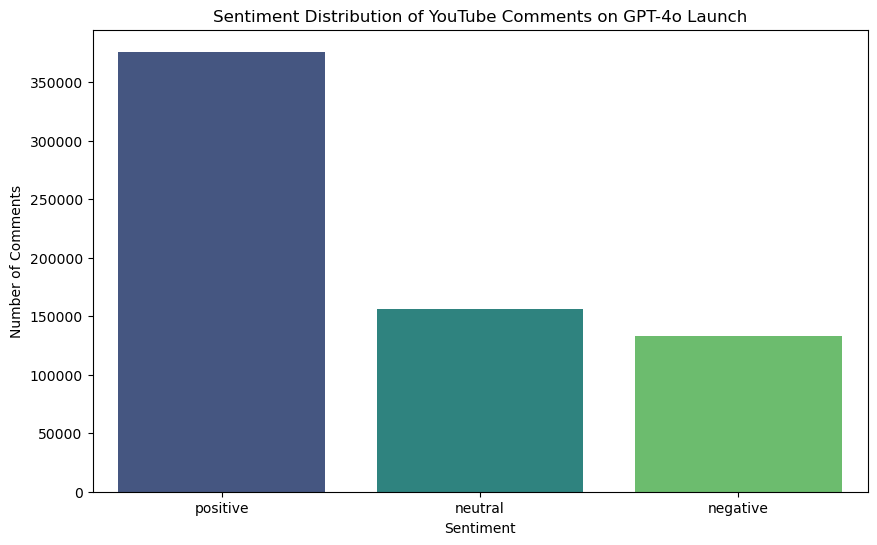

In [58]:
# Create a bar plot for sentiment distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution of YouTube Comments on GPT-4o Launch')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()

In [62]:
# Tokenize the processed comments
openai_youtube_df['Tokens'] = openai_youtube_df['Processed_Comment'].apply(word_tokenize)

# Separate words into positive and negative categories
positive_words = []
negative_words = []

for _, row in openai_youtube_df.iterrows():
    if row['Sentiment'] == 'positive':
        positive_words.extend(row['Tokens'])
    elif row['Sentiment'] == 'negative':
        negative_words.extend(row['Tokens'])

# Count the frequency of each word
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Get the top 10 most frequent words in each category
top_positive_words = positive_word_counts.most_common(10)
top_negative_words = negative_word_counts.most_common(10)

# Convert to DataFrame for better readability
top_positive_df = pd.DataFrame(top_positive_words, columns=['Word', 'Frequency'])
top_negative_df = pd.DataFrame(top_negative_words, columns=['Word', 'Frequency'])

# Display the results
print("Top 10 Positive Words:")
print(top_positive_df)

print("\nTop 10 Negative Words:")
print(top_negative_df)

Top 10 Positive Words:
       Word  Frequency
0        ai     454578
1       job     174853
2  customer     161715
3      dont     136249
4   service     122917
5     would      91089
6       way      90868
7     think      84478
8       get      84467
9       yes      84270

Top 10 Negative Words:
     Word  Frequency
0      ai      46146
1  people      45544
2     job      45441
3    call      45302
4    dont      32564
5    work      32419
6  center      32346
7   human      26145
8     bad      25994
9    time      19585


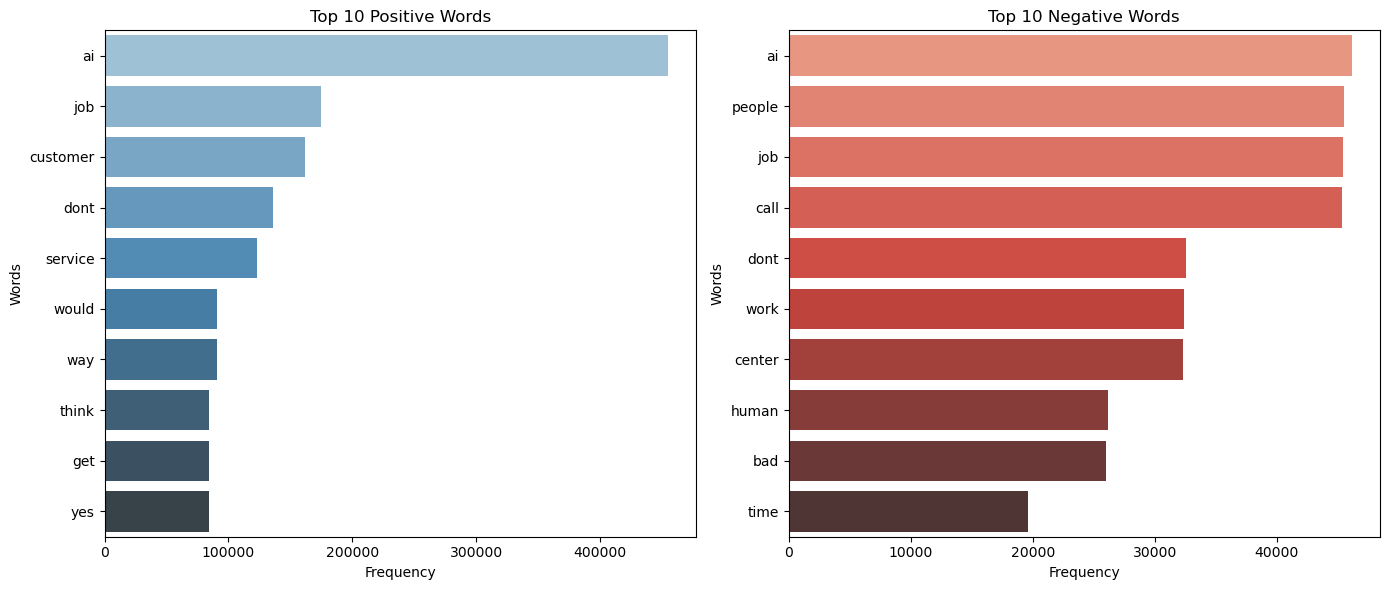

In [65]:
# Create plots
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Frequency', y='Word', data=top_positive_df, palette='Blues_d')
plt.title('Top 10 Positive Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Word', data=top_negative_df, palette='Reds_d')
plt.title('Top 10 Negative Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

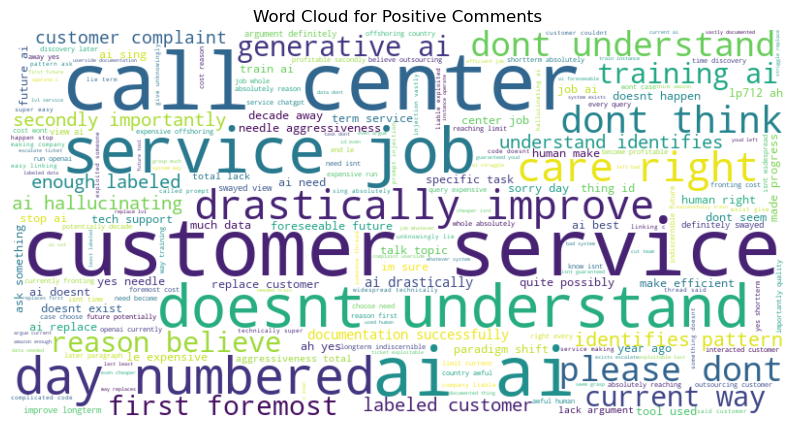

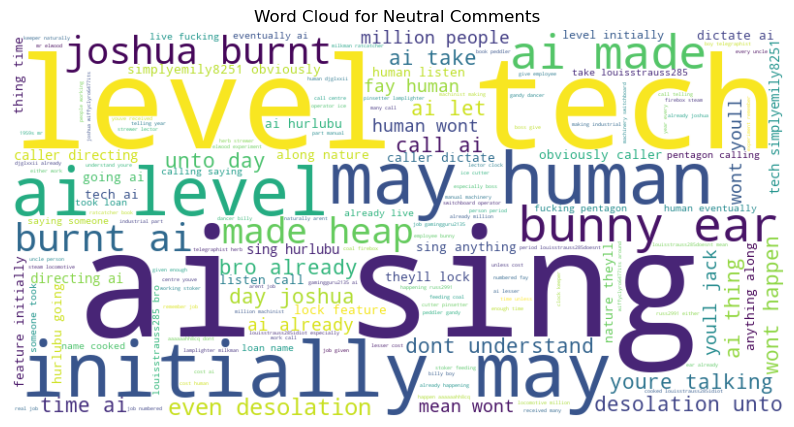

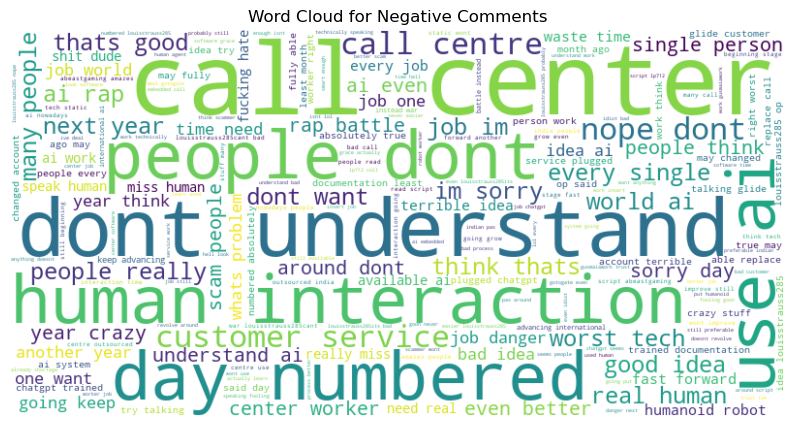

In [66]:
# Plot a word cloud
for sentiment in ['positive', 'neutral', 'negative']:
    text = ' '.join(openai_youtube_df[openai_youtube_df['Sentiment'] == sentiment]['Processed_Comment'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Comments')
    plt.axis('off')
    plt.show()

***

### 5. Findings & Conclusion

**Sentiment Distribution**  
After applying the sentiment analysis, the comments were distributed as follows:
- Positive: 376,079 comments
- Neutral: 156,273 comments
- Negative: 133,446 comments

This distribution indicates that **most comments (over 56%) are positive**, suggesting a **generally favourable reception** of GPT-4o among the YouTube audience. The high number of positive comments suggests that the YouTube audience generally views the introduction of GPT-4o in a positive light. This could indicate satisfaction with the advancements and features presented in the new model.

Neutral comments make up about 23% of the dataset, while negative comments constitute roughly 20%. The presence of a significant number of neutral comments highlights that many viewers are either indifferent or have mixed feelings about GPT-4o. This might require a closer examination of the specific content of these comments to understand their context better. The negative comments, although fewer in comparison, are still substantial. Analyzing these comments in detail can provide insights into users' specific concerns or criticisms about GPT-4o.

**Most Common Words**  
The presence of certain words in both positive and negative contexts (e.g., "ai," "job," and "don't") highlights the complexity of public sentiment towards AI. While many users express excitement and positive outcomes, significant concerns and criticisms remain, particularly regarding job security and the human impact of AI.

**Conclusion**  
The sentiment analysis of over 600,000 YouTube comments on GPT-4o reveals a complex public perception. While the overall sentiment is predominantly positive, reflecting excitement and approval of AI advancements, significant negative sentiment underscores persistent concerns about job security, service quality, and the human impact of AI. This analysis provides valuable insights to understand and address the concerns of OpenAI's audience. These findings align with those reported by Fernandes (2024), which also highlights the mixed reactions on the internet regarding the model.

***

## References

analyticswithadam (2024). _Pull_all_Comments_and_Replies_for_YouTube_Playlists.ipynb_. [online] Github. Available at: https://github.com/analyticswithadam/Python/blob/main/Pull_all_Comments_and_Replies_for_YouTube_Playlists.ipynb [Accessed 27 May 2024].  

Brownlee, J. (2019). _A Gentle Introduction to the Rectified Linear Unit (ReLU) for Deep Learning Neural Networks_. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ [Accessed 25 May 2024].  

Fernandes, J. (2024). _OpenAI Unveils GPT-4o: Here’s How the Internet Reacted to the AI Conversation_. [online] mint. Available at: https://www.livemint.com/companies/news/openai-unveils-gpt4o-from-excitement-worry-warnings-and-memes-how-the-internet-reacted-to-the-ai-conversation-chatgpt-11715656865925.html [Accessed 28 May 2024].

Google (2023). _YouTube Data API  |  Google Developers_. [online] Google Developers. Available at: https://developers.google.com/youtube/v3/docs [Accessed 28 May 2024].  

Grant, A. (2024). _How to Extract All YouTube Comments and Comment Replies from a Playlist_. [online] www.youtube.com. Available at: https://www.youtube.com/watch?v=A1III_DQU4I [Accessed 27 May 2024].  

Haddi, E., Liu, X. and Shi, Y. (2013). The Role of Text Pre-processing in Sentiment Analysis. _Procedia Computer Science_, 17, pp.26–32. doi:https://doi.org/10.1016/j.procs.2013.05.005.  

Hutto, C. and Gilbert, E. (2014). VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text. _Proceedings of the International AAAI Conference on Web and Social Media_, 8(1), pp.216–225. doi:https://doi.org/10.1609/icwsm.v8i1.14550.  

Müller, A.C. and Guido, S. (2017). _Introduction to Machine Learning with Python: A Guide for Data Scientists_. 1st ed. [online] Beijing: O'Reilly Media. Available at: https://moodle.cct.ie/mod/resource/view.php?id=37688 [Accessed 26 May 2024].

OpenAI (2024). _Introducing GPT-4o_ - YouTube. [online] www.youtube.com. Available at: https://www.youtube.com/playlist?list=PLOXw6I10VTv8VOvPNVQ8c4D4NyMRMotXh [Accessed 27 May 2024].  

Rodríguez-Ibánez, M., Casánez-Ventura, A., Castejón-Mateos, F. and Cuenca-Jiménez, P.-M. (2023). A Review on Sentiment Analysis from Social Media Platforms. _Expert Systems with Applications_, 223, p.119862. doi:https://doi.org/10.1016/j.eswa.2023.119862.  

SciKit Learn (2019). _sklearn.model_selection.GridSearchCV — scikit-learn 0.22 Documentation_. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html [Accessed 25 May 2024].